In [1]:
import jax
from cft import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
import optax
from jax import jit, vmap, lax, grad, jacfwd

from functools import partial

from scipy import optimize

jax.config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=20)

from matplotlib.pyplot import cm

"""from jax.config import config
config.update("jax_debug_nans", True)"""

'from jax.config import config\nconfig.update("jax_debug_nans", True)'

In [2]:
import sys
sys.path.append("/home/davep96/anaconda3/envs/conf_boot/lib/python3.7/site-packages")

In [1324]:
def boots(beta,c, params, opt_fn, opt_state, steps=100):
    """ finds deltas

        Params:
        beta - random point for beta
        c - central charge
        deltas - intitialised deltas
        opt_fn - optimization function e.g. Adam
        opt_state - initial state

        Returns:
        losses, deltas, state

    """
#     @jit
    def loss_function(params):
        identy = vmap(reduced_partition_function_spinless, in_axes=(None, 0, None), out_axes=0)(params, beta, c)
        transformed = vmap(reduced_partition_function_spinless, in_axes=(None, 0, None), out_axes=0)(params, 1/beta, c)
#         print(identy.shape)
        return jnp.mean((identy-transformed)**2) # mean squared loss

    losses = []
    for _ in tqdm(range(steps)):
        # loss and gradients calulated with 
        loss, grads = jax.value_and_grad(loss_function)(params) 
        updates, opt_state = opt_fn(grads, opt_state)
        params += updates
        losses.append(loss) 

    return jnp.stack(losses), params, opt_state


100%|████████████████████████████████████████| 800/800 [00:06<00:00, 116.38it/s]


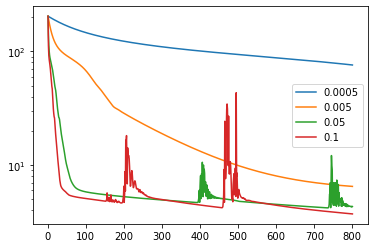

In [1332]:
number_delta = 10
rng = random.PRNGKey(12)
keys = random.split(rng, 2)
batch_size = 128
params = random.uniform(keys[1], (batch_size, 2, number_delta))*2
beta_size = 2*number_delta
beta = (random.uniform(keys[0], (beta_size,)) + 1/2 )
c = 4
step=800

# test for different learning rates
for lr in [5e-4 ,5e-3, 5e-2, 0.1]:
    adam = optax.adam(learning_rate=lr)
#     params = random.uniform(keys[1], (2, number_delta))*2
    params = random.uniform(keys[1], (batch_size, 2, 10))*2
    losses, params, _ = boots(beta, c, params, opt_fn=adam.update, opt_state=adam.init(params),steps=step)
    steps = np.linspace(1,step,step)
    plt.plot(steps,losses,label=f"{lr}")
    plt.yscale("log")
    plt.legend()

    # print(learned_deltas)

In [1333]:
params.shape

(128, 2, 10)

In [1335]:
jnp.sort(params)

DeviceArray([[[ 0.37861199,  0.37862294,  0.83809272, ...,  0.9152998 ,
                0.91793441,  0.9403382 ],
              [ 0.37860556,  0.8097835 ,  0.91130832, ...,  0.91613582,
                0.91669292,  2.07845667]],

             [[ 0.34025298,  7.33085342,  7.54149412, ..., 12.54906638,
               14.77312594, 16.47673069],
              [ 0.34499449,  5.87408497,  7.90694758, ..., 12.59748878,
               13.06718227, 14.87715586]],

             [[ 0.06371786,  0.18590958,  0.33128305, ...,  1.43608001,
                1.44248092,  1.62621345],
              [ 0.12126838,  0.44449996,  0.598009  , ...,  1.62174401,
                1.63637134,  1.78587965]],

             ...,

             [[ 0.06848676,  0.08964665,  0.33792242, ...,  1.49667898,
                1.76248279,  1.82130552],
              [ 0.09261414,  1.01789018,  1.11071099, ...,  1.25261273,
                1.51837084,  1.6275978 ]],

             [[ 0.17539854,  0.24987877,  0.37545894, ...,  1

In [78]:
batch_size = 128
rng = random.PRNGKey(12)
keys = random.split(rng, 2)
beta = (random.uniform(keys[0], (batch_size,)) + 1/2 )
# params = random.uniform(keys[1], (batch_size, 2, 10))*2

step=100000
lr = 0.00005
# params = random.uniform(keys[1], (batch_size, 2, 6))*10

for epoch in range(1):
    key_n, *keys = random.split(key_n, 3)
    # beta = (random.uniform(keys[0], (batch_size,)) + 1/2 )
    c = 3.5
    adam = optax.adam(learning_rate=lr)
    # if epoch > 2:
    # lr = lr/10
    losses, params, _ = boots(beta, c, params, opt_fn=adam.update, opt_state=adam.init(params),steps=step)
    steps = np.linspace(epoch*step+1,(epoch+1)*step,step)
    plt.plot(steps,losses)
    plt.yscale("log")


  5%|▍         | 4521/100000 [00:15<05:24, 294.38it/s]


KeyboardInterrupt: 

## Bootstrap with Newton Raphson and Scipy Optimizers

## Using Scipy optimizers

In [3]:
from jaxopt import ScipyRootFinding
from scipy import optimize

## Using newton-raphson

In [42]:
laguerre_deltas = vmap(laguerre_at_x, in_axes = (None, 0), out_axes=1)

c = 12
x = -(c-1)/12

def primal(params: jnp.array) -> jnp.array:
    """
    Crossing equation with unnormalised rhos    
    
    Args:
        params (jnp.array) [deltas, rhos]
    Returns:
        crossing_equation -> float, crossing equation loss
    """
    h = len(params)//2
    deltas = lax.dynamic_slice(params, (0,),(h,)) # split deltas and rhos
    rhos = lax.dynamic_slice(params, (h,),(h,))
    deltas = deltas + x
    lps = laguerre_deltas(2*h -1,deltas) # calculate laguerre at different deltas
    lp0 = laguerre_at_0(2*h-1, x)# calculate laguerre at zero
    rho_lps = jnp.sum(rhos * lps, axis = 1) # rho * lps
    crossing_equation = (1 + rho_lps/lp0) # lp0 + \Sigma rho* lps = 0
    return  crossing_equation


def newton_rap(primal, x0: jnp.array, tol=1e-10, max_iter=2000) -> (jnp.array,jnp.array,float,bool):
    """
    Finds a solution to `primal` using the Newton-Raphson method. 
    Written with jax while loop.

    Args:
        primal (function): function to approximate a solution of
        x0 (jnp.array): Initial guess for the solution vector.
        tol (float): Tolerance for the norm of the residual vector. Default is 1e-6.
        max_iter (int): Maximum number of iterations. Default is 100.

    Returns:
        x (jnp.array,jnp.array,float,bool): Converging parameters (deltas and rhos), number of steps, converges?
    """

    f = primal

    Jf = jit(jacfwd(f))
    Hf = jax.hessian(f)
    
    hessians = jnp.zeros((2000,6,6,6))
    
    @jit
    def newton_step(val):
        x, r, n,hessians, _ = val # x, f(x), step_number, abort_state
        n = n + 1 
        J = Jf(x)
        hessians = hessians.at[n.astype(int)].set(Hf(x))
        r = f(x)
        dx = jnp.linalg.solve(J, -r)
        x1 = x + dx
        abort = jnp.any(jnp.isnan(x1)) # abort if nan is encountered
        return (jnp.where(abort, x, x1), r , n,hessians, abort)
    
    def cond(val):
        x, r, n,hessians, abort = val
        return (~abort) & (jnp.max(jnp.abs(r)) > tol) & ( n< max_iter) # abort if nan is encountered

    
    return  lax.while_loop(cond, newton_step, (x0, jnp.ones(x0.shape), 0.0, hessians, False))  

@jit
def primal_normal(params):
    """
    Crossing equation with normalised rhos 
    
    params -> [deltas, rhos]
    lps -> laguerre polynomials at deltas
    lp0 -> laguerre at 0
    Crossing equation with normalised rhos -> rhos * \sqrt(max(lps))
    """
    h = len(params)//2
    deltas = lax.dynamic_slice(params, (0,),(h,))
    rhos = lax.dynamic_slice(params, (h,),(h,))
    deltas = deltas + x
    lps = laguerre_deltas(2*h -1,deltas)
    maxl = jnp.max(jnp.abs(lps), axis=0)
    lps = lps/jnp.sqrt(maxl)
    lp0 = laguerre_at_0(2*h-1, x)
    rho_lps = jnp.sum(rhos * lps, axis = 1)
    crossing_equation = (1 + rho_lps/lp0)
    return  crossing_equation

@jit
def primal_normal_optim(rhos,deltas):
    """
    Mean squared loss of the crossing equation
    Args:
        rhos (jpn.array(float)) rhos
        deltas (jpn.array(float)) deltas
    Returns:
        Mean square loss (float)
    """
    
    h = len(deltas)
#     deltas = lax.dynamic_slice(params, (0,),(h,))
#     rhos = lax.dynamic_slice(params, (h,),(h,))
    deltas = deltas + x
    lps = laguerre_deltas(2*h -1,deltas)
    maxl = jnp.max(jnp.abs(lps), axis=0)
    lps = lps/jnp.sqrt(maxl)
    lp0 = laguerre_at_0(2*h-1, x)
    rho_lps = jnp.sum(rhos * lps, axis = 1)
    crossing_equation = (1 + rho_lps/lp0)
    return  jnp.linalg.norm(crossing_equation)/h

In [43]:
deltas = jnp.array([2.1,3.4,5.1], dtype=float)
rhos = jnp.array([1]*3, dtype=float)

In [44]:
newt_rap_f = partial(newton_rap,primal)

In [189]:
deltas = jnp.array([2.1,3.4,5.1], dtype=float)
out = newt_rap_f(jnp.concatenate((deltas,rhos)))

In [179]:
[jnp.sum(jnp.log10(jnp.abs(jnp.linalg.det(out[-2][i])))) for i in range(int(out[-3]))]

[DeviceArray(-inf, dtype=float64),
 DeviceArray(-75.34281553035413, dtype=float64),
 DeviceArray(772.0594153200669, dtype=float64),
 DeviceArray(inf, dtype=float64)]

In [181]:
[jnp.sum(jnp.log10(jnp.abs(jnp.linalg.det(out[-2][i])))) for i in range(int(out[-3]))]

[DeviceArray(-inf, dtype=float64),
 DeviceArray(15.860035838932912, dtype=float64),
 DeviceArray(18.410068825121847, dtype=float64),
 DeviceArray(11.073452434028049, dtype=float64),
 DeviceArray(178.8138936379224, dtype=float64),
 DeviceArray(290.1174965477866, dtype=float64),
 DeviceArray(578.5529338415143, dtype=float64),
 DeviceArray(616.8324399576804, dtype=float64)]

In [188]:
jnp.var(jnp.array([float(t) for t in Out[181][1:]]))

DeviceArray(59214.112689100686, dtype=float64)

In [190]:
[jnp.sum(jnp.log10(jnp.abs(jnp.linalg.det(out[-2][i])))) for i in range(int(out[-3]))]

[DeviceArray(-inf, dtype=float64),
 DeviceArray(22.45841717827532, dtype=float64),
 DeviceArray(22.894702980976895, dtype=float64),
 DeviceArray(20.342107601473185, dtype=float64),
 DeviceArray(21.692024128649205, dtype=float64),
 DeviceArray(21.693267890591187, dtype=float64)]

In [191]:
jnp.var(jnp.array([float(t) for t in Out[190][1:]]))

DeviceArray(0.7558183775739348, dtype=float64)

In [114]:
jnp.linalg.det(out[-2][1])

DeviceArray([-1.0227695425576850e+00, -2.9091554769558064e+05,
             -8.0445752114724694e+06, -1.0632029339031046e+06,
             -1.1430461094089957e+04, -1.6072292012027914e-01],            dtype=float64)

In [112]:
out

(DeviceArray([2.1317077922680436e+00, 3.4345579133998450e+00,
              5.1288629421203300e+00, 7.2653863900192661e-01,
              6.9310807635990374e-02, 5.5532667447074301e-04],            dtype=float64),
 DeviceArray([ 1.1102230246251565e-16,  1.1102230246251565e-16,
               2.2204460492503131e-16,  4.4408920985006262e-16,
               4.4408920985006262e-16, -6.6613381477509392e-16],            dtype=float64),
 DeviceArray(7., dtype=float64, weak_type=True),
 DeviceArray([[[[ 0.0000000000000000e+00,  0.0000000000000000e+00,
                  0.0000000000000000e+00,  0.0000000000000000e+00,
                  0.0000000000000000e+00,  0.0000000000000000e+00],
                [ 0.0000000000000000e+00,  0.0000000000000000e+00,
                  0.0000000000000000e+00,  0.0000000000000000e+00,
                  0.0000000000000000e+00,  0.0000000000000000e+00],
                [ 0.0000000000000000e+00,  0.0000000000000000e+00,
                  0.0000000000000000e+00,  0.0

In [16]:
def rhos_optim(rhos, deltas, opt_fn, opt_state, steps=100):
    """ Guess rhos, given a good guess for deltas

        Params:
        rho - initial values for rhos (arbitrary)
        deltas - intitialised deltas (fixed)
        opt_fn - optimization function e.g. Adam
        opt_state - initial state

        Returns:
        rhos, losses,  state

    """
    c = 12
    x = -(c-1)/12
    h = len(deltas)
    deltas = deltas + x
    @jit
    def loss_function(rhos): # same as primal_normal
        lps = laguerre_deltas(2*h -1,deltas)
        maxl = jnp.max(jnp.abs(lps), axis=0)
        lps = lps/jnp.sqrt(maxl)
        lp0 = laguerre_at_0(2*h-1, x)
        rho_lps = jnp.sum(rhos * lps, axis = 1)
        crossing_equation = (1 + rho_lps/lp0)
        return jnp.mean((crossing_equation)**2) # mean squared loss

    losses = []
    for _ in tqdm(range(steps)): # optimiser
        loss, grads = jax.value_and_grad(loss_function)(rhos) # loss and gradients calulated 
        updates, opt_state = opt_fn(grads, opt_state) 
        rhos += updates # update rho
        losses.append(loss) 

    return  rhos, jnp.stack(losses), opt_state

In [17]:
def dilation(dnm1,dn, fixed_point = 1, some_point = 0):
    """Calculate scaling factor \epsilon for self-similar function: 
        f(\lambda x) = \lambda^{\epsilon} f(x)
        
        Args:
        dnm1: x
        dn: \lambda x
        fixed_point:
        some_point:
        
        Returns:
        epsilons: \epsilon
    """
    h =  len(dnm1) - some_point if len(dnm1) - some_point> 0 else len(dnm1)
    lambda_= (h+1 - fixed_point)/(h - fixed_point)
    epsilon = jnp.log((dn[h+1]-dn[fixed_point-1])/(dnm1[h] - dnm1[fixed_point-1]))/jnp.log(lambda_) 
    return epsilon

def guess_generator(dnm1, dn, fixed_point=1):
    """generate guess dnp1 from dnm1 and dn
        
        Args:
        dnm1: x
        dn: \lambda x
        fixed_point:
        
        Returns:
        guess: dnp1
    """
    
    epsilon = dilation(dnm1, dn, fixed_point,0)
    no_points = 1000
    x_range = jnp.linspace(1.0,int(len(dn)),(int(len(dn))- 1)*no_points)
    
    x_discrete = jnp.arange(1, int(len(dn)) + 1, dtype = float)
    
    yn = jnp.interp(x_range, x_discrete, dn)
    
    lambda_ = (len(dn))/(len(dn) - 1)
    
    scale = lambda_ ** epsilon
    
    ynp1 = (yn - yn[0]) * scale + yn[0]
    sample_rate = int((no_points-1)/ lambda_)
    # Correction added to guess
    cors = jnp.array([0.007866155585121012, 0.00954485954845927 , 0.014117004802336118,
       0.023951187818932042, 0.046797643955721294, 0.10137571941656    ])
    guess = ynp1[::sample_rate]
    guess= guess.at[-6:].add(cors)
    return guess

number of deltas = 3
number of deltas = 4
number of deltas = 5
number of deltas = 6
number of deltas = 7
number of deltas = 8
number of deltas = 9
number of deltas = 10
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in while

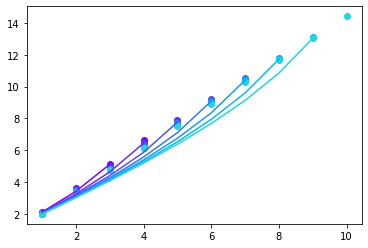

In [9]:
laguerre_deltas = vmap(laguerre_at_x, in_axes = (None, 0), out_axes=1)
color = iter(cm.rainbow(np.linspace(0, 1, 20)))

c = 12
x = -(c-1)/12

list_losses = []
list_params = []
list_guesses = []
deltas = jnp.array([2.12, 3.43, 5.13])
a_mus = jnp.ones(deltas.shape, dtype = float)*1
params = jnp.array([deltas,a_mus])
params = params.flatten()

list_guesses.append(params)
rng = random.PRNGKey(1)
keys = random.split(rng, 2)

for p in range(4,12):
    col = next(color)
    print(f"number of deltas = {p-1}")
    
    
    guess = params    
    params, *others = nr_primal(x0 = params)
        
        
    if others[2]:
        print(f"nan found delta {p-1}")
        print("guess")
        print(guess)
        print("params")
        print(params)
        break
        
    list_params.append(params)
    list_losses.append(primal(params))
    
    
    r = p-2
    k = 1
    
    h = len(params)//2
    deltas = lax.dynamic_slice(params, (0,),(h,))
    
    x_ind = jnp.arange(1,p, dtype= float)
    plt.plot(x_ind,deltas, color=col)
    
    amus = jnp.ones(p, dtype=float)*k
    scale = (deltas[r] - deltas[0])/(r)
    
    keys = random.split(keys[1],2)
    
    
    new_deltas = (scale * (jnp.arange(p)) + deltas[0] ) + random.uniform(keys[1], jnp.arange(p).shape) * 0.1/p    
    
   
    x_ind = jnp.arange(1,p+1, dtype= float)
    plt.scatter(x_ind,new_deltas, color = col)
    params = jnp.array([new_deltas,amus]).flatten()
    list_guesses.append(params)
    if p == 11:
        print("guess")
        print(params)

plt.plot(x_ind,new_deltas)
plt.plot(x_ind, 1 + x_ind)

In [1421]:
list_losses

[DeviceArray([-2.22044605e-16, -2.22044605e-16, -2.22044605e-16,
              -6.66133815e-16, -1.55431223e-15, -2.44249065e-15],            dtype=float64),
 DeviceArray([ 1.11022302e-16,  3.33066907e-16,  8.88178420e-16,
               5.55111512e-16,  2.22044605e-16,  3.33066907e-16,
              -2.22044605e-16, -2.22044605e-16], dtype=float64),
 DeviceArray([ 1.11022302e-16, -2.22044605e-16, -8.88178420e-16,
              -6.66133815e-16, -2.22044605e-16, -2.22044605e-16,
              -2.22044605e-16, -1.11022302e-15, -2.66453526e-15,
              -3.99680289e-15], dtype=float64),
 DeviceArray([ 0.00000000e+00, -2.22044605e-16,  0.00000000e+00,
              -2.22044605e-16, -2.22044605e-16, -6.66133815e-16,
              -1.11022302e-15, -1.33226763e-15, -1.33226763e-15,
              -1.33226763e-15, -6.66133815e-16, -6.66133815e-16],            dtype=float64),
 DeviceArray([ 1.11022302e-16,  2.22044605e-16,  0.00000000e+00,
               1.11022302e-16,  1.11022302e-16, -2.

In [153]:
list_params

[DeviceArray([2.1317077922680436e+00, 3.4345579133998454e+00,
              5.1288629421203309e+00, 7.2653863900192672e-01,
              6.9310807635990318e-02, 5.5532667447074225e-04],            dtype=float64),
 DeviceArray([2.0811133956832402e+00, 3.2639281955913151e+00,
              4.6513903315237819e+00, 6.4502049247322848e+00,
              7.1628415647350008e-01, 9.3342091051700674e-02,
              2.0470462135811535e-03, 5.0206551839411923e-06],            dtype=float64),
 DeviceArray([2.0524040148793965e+00, 3.1700080874847241e+00,
              4.4146115985187446e+00, 5.8785778582483488e+00,
              7.7691247395614491e+00, 7.0774478356108439e-01,
              1.0843346313186764e-01, 3.7741037729852110e-03,
              3.1294760674281467e-05, 3.0565078062830900e-08],            dtype=float64),
 DeviceArray([2.0350381802830926e+00, 3.1137220531908305e+00,
              4.2770916146359808e+00, 5.5802827105955455e+00,
              7.1134024986546702e+00, 9.08616441

In [154]:
list_guesses

[DeviceArray([2.12, 3.43, 5.13, 1.  , 1.  , 1.  ], dtype=float64),
 DeviceArray([2.1467345642628493, 3.636151017591032 , 5.144902525677382 ,
              6.644776315099856 , 1.                , 1.                ,
              1.                , 1.                ], dtype=float64),
 DeviceArray([2.0841683015733015, 3.5535620922139923, 5.009391134090036 ,
              6.46225073142989  , 7.917785494874783 , 1.                ,
              1.                , 1.                , 1.                ,
              1.                ], dtype=float64),
 DeviceArray([2.0610914827542266, 3.4885496831637846, 4.913585758028263 ,
              6.3558612074573   , 7.771210359921089 , 9.209656566834882 ,
              1.                , 1.                , 1.                ,
              1.                , 1.                , 1.                ],            dtype=float64),
 DeviceArray([ 2.0362048573065437,  3.4594606663369842,
               4.860270346851098 ,  6.2720618072411085,
     

In [18]:
list_params_n = []
list_deltas=[]
list_guesses = []
#deltas at 10
deltas_nm1 = jnp.array([2.0087250774670635e+00, 3.0284738337579089e+00,
              4.0702579984187093e+00, 5.1489830905152969e+00,
              6.2846424950416377e+00, 7.5030369320194046e+00,
              8.8383108750694248e+00, 1.0340822370332926e+01,
              1.2100429543282575e+01, 1.4340733644624255e+01])

#delta at 11
deltas_n = jnp.array([ 2.0087250774670684,  3.003572694143946 ,
              4.0170404711910646,  5.05977751818666  ,
              6.145403599576878 ,  7.290835270242067 ,
              8.517198395370421 ,  9.8520027755382   ,
             11.333659047501556 , 13.100298554534404 ,
             15.602738195447228])

# a_mus = jnp.array([9.3752351008611274e+00, 4.4929261201295596e+01,
#        7.2318721831577193e+01, 6.3074912091117852e+01,
#        4.3204885219588775e+01, 2.1197389391231862e+01,
#        7.1262995497691684e+00, 1.8737659240062021e+00,
#        3.0516249443686172e-01, 3.6314089832267180e-02,
#        5.1417535858557049e-04])

deltas_g = deltas_n
deltas_n = deltas_nm1
adam = optax.adam(learning_rate=0.2)
a_mus = jnp.ones(deltas_g.shape, dtype = float) * 1
h = len(deltas_g)

for p in range(11, 40):
    print(f"run {p}")
    
    a_mus_ = jnp.ones(deltas_g.shape, dtype = float) * 1
    a_mus = a_mus_.at[0:h].set(a_mus)
    if p < 25:
        a_mus, losses, _ = rhos_optim(a_mus, deltas_g, opt_fn=adam.update, opt_state=adam.init(a_mus), steps=2000)
    else:
        res = optimize.minimize(primal_normal_optim, a_mus, args=(deltas_g), method="Nelder-Mead", tol=1e-15, options={"maxiter": 5000, "xatol": 1e-15}) 
        a_mus = res.x

    params = jnp.array([deltas_g,a_mus])
    params = params.flatten()

    params, *others = nr_primal_normal(x0 = params)

    if not others[2]: # if converges
        c = 12
        x = -(c-1)/12
        list_params_n.append(params)
        deltas_nm1 = deltas_n
        h = len(params)//2
        deltas_n = lax.dynamic_slice(params, (0,),(h,))
        list_deltas.append(deltas_n)
        print(primal_normal(params))
    else:
        print("aborted due to nan")
        break
        
    deltas_g = guess_generator(deltas_nm1, deltas_n, fixed_point=1) #+ jnp.arange(p+1)/(3*p)
    list_guesses.append(deltas_g)
    print(f"new guess \n{deltas_g}")


run 11


100%|████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 166.44it/s]


[-3.3617553185649740e-13 -1.2232437285319975e-12 -3.2922553572234392e-12
 -7.5324191328718371e-12 -1.4780621171439634e-11 -2.4426682898592844e-11
 -3.6577185724695482e-11 -6.0482951980134203e-11 -1.0847744924546987e-10
 -1.7233792171111872e-10 -2.3227242351708810e-10 -4.0118619537565792e-10
 -1.1426852797313813e-09 -2.9725317762796521e-09 -5.3703799185456091e-09
 -6.4724237081037472e-09 -4.9365203036444427e-09 -2.2514956565800048e-09
 -2.5103914502722091e-09 -6.5145822070178383e-09 -4.7007171488644417e-09
  1.1709715974639323e-08]
new guess 
[ 2.0064059026108767  3.016000975279164   4.040188609870416
  5.0879519169074445  6.17112456966861    7.304565233485607
  8.51446596950107    9.809932281303595  11.231391876647006
 12.828640801776968  14.693470873645676  17.033582683159235 ]
run 12


100%|████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 171.40it/s]


[-2.6126699352868599e-06 -1.6368453135129357e-06  2.6872370071373552e-06
  1.9891937306337759e-05  7.5324632164974759e-06 -3.9871333065377712e-05
 -2.9762069910121980e-05 -6.4497998599089001e-05 -3.6926553525518102e-04
 -5.7593923316079376e-04 -1.6226991434464821e-04  3.9567445429600223e-04
  4.4302962486286734e-04  4.8294442719953867e-04  1.1392057418920798e-03
  1.8793605879467989e-03  1.9837174254558887e-03  1.8281197439276031e-03
  2.4640929734340844e-03  4.3464273086482041e-03  7.2446942523041180e-03
  1.0603313493939392e-02  1.3965982366795693e-02  1.7333435623830051e-02]
new guess 
[ 2.004792813778126   3.010134572860044   4.026560487979243
  5.0612804441697605  6.1231866290011645  7.225548093462662
  8.380986712582743   9.615980189204736  10.939641370240151
 12.38990187577666   14.018960886227967  15.91501568573099
 18.30320989721139  ]
run 13


100%|████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 174.39it/s]


[-5.7385030061141151e-10 -2.3002360016732837e-09 -6.7230119249472864e-09
 -1.6777887301699934e-08 -4.0438505433115779e-08 -9.8989797914228461e-08
 -2.3972984819486953e-07 -5.5497899942302809e-07 -1.1807040014577552e-06
 -2.1421195366411183e-06 -2.9264371077530882e-06 -2.3755655969015521e-06
 -5.4172088370663118e-08  2.3305319489796972e-06  2.9488599886384748e-06
  2.4170534421719125e-06  1.7768059075162768e-06  1.0246676886982442e-06
  5.6420425020853315e-07  4.7265820457553787e-07  3.7553684784086272e-07
  3.8279976644073344e-07  4.7449007245514707e-07  5.9579680733445883e-07
  7.6721756947506492e-07  9.0436593014331379e-07]
new guess 
[ 2.003569962162693   3.0083579611030906  4.021542699358159
  5.04862831505635    6.097178792436756   7.1769864227703195
  8.300119271668283   9.481099968902903  10.745470594168069
 12.101709993027743  13.589998780594522  15.260745310254784
 17.208251630117953  19.655642070004937 ]
run 14


100%|████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 183.51it/s]


[-2.8000934904071073e-11 -1.1099920982360345e-10 -3.1480795747995671e-10
 -7.3400530098410854e-10 -1.5671832720443035e-09 -3.2665823379574022e-09
 -6.6627159345244991e-09 -1.3092166017969475e-08 -2.4429712697227046e-08
 -4.2873263828013819e-08 -7.0247751615681864e-08 -1.0628540292323407e-07
 -1.4695132688480328e-07 -1.8332018303368613e-07 -2.0067466488526975e-07
 -1.8222283504343295e-07 -1.2050950348729828e-07 -3.2213813616621678e-08
  4.4753962313848206e-08  1.3332787041075989e-07  5.4257838666416092e-07
  2.1538378383034740e-06  6.3499905557096170e-06  1.3926168437761177e-05
  2.3341177532665291e-05  3.1159116170242918e-05  3.6097019928571505e-05
  3.9956780264249758e-05]
new guess 
[ 2.0027034557821475  3.004786085114465   4.013289673260128
  5.0325190600284895  6.068501395991491   7.129190775624484
  8.224519123618547   9.366432728345488  10.569148343743265
 11.857818983970391  13.240572161019223  14.757383790231405
 16.458634748074136  18.438577618991413  20.932327879899514 ]
run 

100%|████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 182.39it/s]


[-2.5638047240761352e-10 -9.7661412290506178e-10 -2.6017459298088852e-09
 -4.9714039551673750e-09 -7.3791810439871597e-09 -1.3615204741412867e-08
 -3.3954203448871567e-08 -7.2235841974688242e-08 -1.2027805795788993e-07
 -1.5862446844927547e-07 -1.4969113215634877e-07 -6.5831963658169457e-08
  9.3303014203627299e-08  3.3273087773899590e-07  6.1034181608743410e-07
  6.6314972901881930e-07  8.7194813702673457e-08 -1.0726937125227209e-06
 -2.0377372040858432e-06 -2.2626107398782125e-06 -2.3758670273377192e-06
 -3.1606846333520622e-06 -4.2960346873233135e-06 -5.1450115501339155e-06
 -5.8157255176105593e-06 -6.9250989709335187e-06 -8.6727000043751445e-06
 -1.0298087259386079e-05 -1.0648829033010898e-05 -9.2303191341347457e-06]
new guess 
[ 2.002064441611697  3.003249312831427  4.009386780007574
  5.023862158578556  6.051494740567541  7.09876740212143
  8.17391306790933   9.286915407916403 10.449568670759012
 11.675820498156687 12.990557216574521 14.401761781972828
 15.949506141633432 17.6847

100%|████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 183.26it/s]


[ 5.6886606536465933e-11 -1.5210277481969570e-11 -7.7418715882515698e-10
 -2.1332562383236109e-09 -4.7495840593825278e-09 -1.2048891440130660e-08
 -2.7714216255247948e-08 -5.7027975675083553e-08 -9.8512100255021551e-08
 -1.2984277786287635e-07 -1.1937580590704044e-07 -7.3087900398505212e-08
 -5.3835219615550045e-08 -8.5450225562055948e-08 -3.4678162341705843e-08
  3.7696349841631616e-07  1.6090112963107472e-06  4.4377853792854083e-06
  9.4996613768660865e-06  1.5807809092271974e-05  1.9640938918041861e-05
  1.6714696082553715e-05  7.4504100722183608e-06 -1.7814836179574911e-06
 -5.7405365228024863e-06 -5.9333202171441002e-06 -6.2299756089512215e-06
 -7.6062276344046609e-06 -9.6482423472821210e-06 -1.2674130192902311e-05
 -1.7201302999536594e-05 -2.3256866514387298e-05]
new guess 
[ 2.0015884829544595  3.0017571683292963  4.005765264188625
  5.0162776622220875  6.0371415229682475  7.073623644893641
  8.132534605630774   9.222245420834696  10.352672997580338
 11.53538767371608   12.78404

100%|████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 180.00it/s]


[ 6.6083027938645955e-11 -6.8627836746770754e-10 -1.9666319683864231e-09
 -5.3449251691262134e-09 -5.5126458953225210e-09  1.9014946284201528e-09
  5.6803455272813608e-09  9.6639607427562169e-10 -3.5836145162448929e-09
 -9.0443481592927810e-09 -1.7359074622191883e-08 -2.8185480838160970e-08
 -4.1651816218291060e-08 -5.6535210735120245e-08 -6.9787668754983656e-08
 -7.0710848731891929e-08 -3.4613824029250395e-08  6.8379242601501744e-08
  2.2945497546444926e-07  3.4532920034635595e-07  2.5271168813123523e-07
 -1.0572751385495849e-07 -5.9052228285061403e-07 -1.0213078263099362e-06
 -1.3399963063598364e-06 -1.5612186328173294e-06 -1.7243337946393211e-06
 -1.9016802121907261e-06 -2.1252686923656228e-06 -2.4340521835863882e-06
 -2.9567274235642316e-06 -3.8652758220791839e-06 -5.4070960970875603e-06
 -7.7714407484830161e-06]
new guess 
[ 2.0012307931188027  3.001131829232821   4.004029668494909
  5.012031942137725   6.028218205824368   7.056871522932408
  8.103630501591633   9.175539941492389 

100%|████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 181.36it/s]


[ 5.1261861422347010e-10 -7.8757445010069205e-10 -1.0655674120840786e-09
 -2.9157103398347317e-09 -4.7033186234557434e-09 -5.2051498666827456e-09
 -5.8343552211681526e-09 -3.8703491522795730e-09 -2.0703370129382392e-09
 -7.3688208868105676e-09 -1.8945329749442408e-08 -3.6166298844619860e-08
 -6.0393170908668026e-08 -9.4022212904221192e-08 -1.3914604579667866e-07
 -1.9449512111968659e-07 -2.5073947274023567e-07 -2.8203096391621330e-07
 -2.4436272583194807e-07 -1.0177457610005547e-07  1.1034718738756055e-07
  2.3634452073206802e-07  7.0514465599913478e-08 -4.4764470041869231e-07
 -1.1500065877356747e-06 -1.8200089240139050e-06 -2.3643183522104039e-06
 -2.7814115015623031e-06 -3.1358262175817941e-06 -3.5352585998627006e-06
 -4.0251302255711607e-06 -4.6814303586995010e-06 -5.7447399484100714e-06
 -7.6016094279207636e-06 -1.0892213516244809e-05 -1.6324232336328848e-05]
new guess 
[ 2.0009597931322056  3.000131117464073   4.001651121439208
  5.007188430549105   6.019204942435115   7.04117141

100%|████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 182.13it/s]


[ 5.2640847236773425e-10 -8.1066575674526575e-10 -1.5048586821109211e-09
 -4.1535725969765735e-09 -4.5591985742277075e-09 -9.8302566087227206e-10
 -1.2966929752167289e-09 -3.4034974838448306e-09 -1.0541845174572018e-09
  5.2498738689621405e-10  4.7095649602368894e-10  2.9255134981198694e-09
  2.2570024071910666e-08  1.3485577488037137e-07  6.4580690706250721e-07
  2.5235282732349873e-06  8.0811300614547221e-06  2.1130655917578345e-05
  4.4686346544087208e-05  7.5238594013482540e-05  9.8400059616920998e-05
  9.5938101503323381e-05  6.4456436903448378e-05  2.4299861682175461e-05
  4.0666442302494943e-07 -3.2985494429205175e-06 -4.4475947258426629e-07
  6.6079347993408533e-08 -5.3132819055612401e-07 -5.2430029873207218e-07
 -4.7153820603718088e-07 -5.3428792168297434e-07 -5.5551151167954060e-07
 -5.8245737877271608e-07 -6.4321245352161327e-07 -8.1414990327211001e-07
 -1.2720519808606667e-06 -2.2233875323074415e-06]
new guess 
[ 2.0007529185141015  2.9996775247849747  4.00045375846815
  5.

100%|████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 181.33it/s]


[ 9.0336726987771954e-10 -1.8009340685409825e-09 -1.4767731482123736e-09
 -1.6864416529926984e-09 -3.6491565325036390e-09 -6.1637239756606732e-09
 -5.9488938219942611e-09 -3.6826506288889505e-09 -3.7293836907537070e-09
 -3.2702438534926159e-09 -4.0156655778389450e-10  1.1764458296426028e-09
  1.5408481157663800e-09  1.5109554718506502e-09  7.0937666851733638e-10
  9.3710594839535588e-12  9.8553332161799290e-10  4.7338739594948720e-09
  1.1491949059028173e-08  2.0113975929270111e-08  2.7520566270311519e-08
  2.9247425148426487e-08  2.1850526499278544e-08  5.7016035226453710e-09
 -1.6601781949177052e-08 -4.7442596295965700e-08 -9.5235711095043030e-08
 -1.6064245955682566e-07 -2.2761508966517852e-07 -2.7810206693068551e-07
 -3.0801963357696138e-07 -3.2239338598749612e-07 -3.2930903937078426e-07
 -3.3595469584035698e-07 -3.3515657804628063e-07 -3.1403521338901896e-07
 -2.8610259605876820e-07 -3.2318359721728029e-07 -5.9552189557443569e-07
 -1.3407873240556256e-06]
new guess 
[ 2.0005939047

100%|████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 182.52it/s]


[ 2.0200985328955312e-10 -2.8666913287622720e-10 -3.0143354479150730e-10
 -8.1368756177369050e-10 -1.6946970493592062e-09 -2.4300996770421079e-09
 -2.6136472985882619e-09 -2.0268717815241644e-09 -1.7050230116666398e-09
 -1.6162911009587333e-09 -1.3909817742074893e-09 -1.8840911053530363e-09
 -2.6735909042230332e-09 -3.2287497120364606e-09 -3.2144091832719823e-09
 -1.6352066367630869e-09  2.6712918543836395e-09  1.0700041408462369e-08
  2.3413326277754720e-08  4.2321473769924012e-08  7.0831828846706912e-08
  1.1658178566964494e-07  1.9373836557257107e-07  3.1944496536873146e-07
  4.9286652248348162e-07  6.5459190889960439e-07  6.6701802770019469e-07
  3.9064666146337856e-07 -1.5398599617633124e-07 -7.3039669779006999e-07
 -1.0962557597249400e-06 -1.2530422661694018e-06 -1.3660028379547384e-06
 -1.5018982502112976e-06 -1.6177337431866334e-06 -1.7038728910012679e-06
 -1.7635210216582209e-06 -1.7850086710957669e-06 -1.8553351075478730e-06
 -2.2998952793340521e-06 -3.8549366010443009e-06 -7

100%|████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 182.68it/s]


[ 3.5587321978169939e-10 -5.4469762034159430e-10 -1.2232350687924054e-09
 -3.5021896493958593e-09 -6.7983483287292756e-09 -9.9023982347290485e-09
 -1.1482982564814392e-08 -1.0812774231538924e-08 -1.1093651997029497e-08
 -1.3962751843621390e-08 -2.2371128061138279e-08 -3.6497293631754246e-08
 -4.7674349135107263e-08 -6.3102359781908035e-08 -1.0153684315561406e-07
 -1.5756316984472107e-07 -1.9388181815571670e-07 -1.7764047366419788e-07
 -1.2219506784205691e-07 -6.8054878843426536e-08 -3.3748332350924670e-08
 -1.8870889961775106e-08 -2.3548763383729465e-08 -4.5178570218240566e-08
 -8.1974619092761714e-08 -1.4183536345413472e-07 -2.4362356465523760e-07
 -4.0461773731514938e-07 -6.0818034430809575e-07 -7.8292099825461037e-07
 -8.4198386907097245e-07 -7.7430629041863597e-07 -6.7755421495618862e-07
 -6.5456066433711158e-07 -6.9575129080234888e-07 -7.1528121536879041e-07
 -6.7343608911585306e-07 -6.0084689357253751e-07 -5.3583421522063190e-07
 -5.0038114451922411e-07 -5.2103356940058632e-07 -6

100%|████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 182.35it/s]


[-9.3047793914280419e-09 -3.0670871398186250e-08 -5.4745111333076579e-08
 -5.9968595644832590e-08 -6.0572152182913896e-08 -7.2695138353395805e-08
 -1.1706986269288677e-07 -2.4133864995334875e-07 -5.1168309656013378e-07
 -1.1435056308517488e-06 -2.2512774924265955e-06 -3.5242997120654707e-06
 -4.8153236678061262e-06 -7.2494359817376619e-06 -1.2757975379917852e-05
 -2.1346718039216839e-05 -2.9097544015588284e-05 -3.1411224267641202e-05
 -2.8606572957778909e-05 -2.4358671413926558e-05 -2.0244546379499795e-05
 -1.6292989573507555e-05 -1.3154154470784718e-05 -1.1181968272433451e-05
 -1.0031575294444650e-05 -9.0470543692156014e-06 -7.8366882549918415e-06
 -6.8630306127026586e-06 -6.7948583408750096e-06 -7.4608062989867108e-06
 -7.8633372886383057e-06 -7.2611870205463447e-06 -5.6917128963274166e-06
 -3.6863465542325002e-06 -2.0341582127603175e-06 -1.5142982394689142e-06
 -2.4855632960729679e-06 -4.8632325286845912e-06 -8.6365867266735563e-06
 -1.4059873377103571e-05 -2.1250223906976728e-05 -2

100%|████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 182.14it/s]


[ 3.0869859335425076e-08  4.7153561055779392e-09 -2.3846978902675176e-07
 -3.8473558849894118e-07 -4.8405037755827607e-08  2.6445503498173650e-07
  1.8901312104357970e-07 -1.3330320403071028e-08 -3.3999451254373980e-08
  1.7038731536800356e-08  6.5030709262003938e-08  8.7986786745375412e-08
  5.8083482357140781e-08  2.4234351303498158e-08  9.6343538702470255e-09
  4.8763252324945938e-09  1.3682306398976607e-09 -2.7644375677482458e-10
  6.1525834427200721e-09  1.5401664166247997e-08  2.0383314369709638e-08
  2.3444609476008793e-08  2.5718914886674327e-08  2.5362465350120544e-08
  2.2590334047833949e-08  1.9168634901589598e-08  1.6076274089726894e-08
  1.3360930695149875e-08  1.1184441595091243e-08  1.0042373044250041e-08
  1.0111052550776378e-08  1.0878970613248384e-08  1.1142426870058841e-08
  9.7042768265609425e-09  6.5685143990634742e-09  3.1578814008170752e-09
  9.1486718201139183e-10 -1.8007995095103979e-10 -1.2035796803644416e-09
 -2.8661362172499594e-09 -5.3509192632361646e-09 -8

new guess 
[ 2.0001046021316817  2.9983382997126418  3.9968355546884267
  4.9957925356800725  5.995510686086982   6.996441273953527
  7.999241071935578   9.004840132918265  10.014518297260702
 11.029983340392516  12.053439116188386  13.08763000550488
 14.135851280792386  15.20192445433818   16.290150381099522
 17.405264695404846  18.55242461459361   19.73725331777101
 20.965962761155964  22.245574700721757  23.58426936673219
 24.991917854005013  26.48090973721567   28.07536872661982
 29.783725012801096  31.648285770954445  33.72516625287519
 36.12133569089166   39.14240324739787  ]
run 29
Invalid value encountered in the output of a jit-decorated function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in while

IndexError: list index out of range

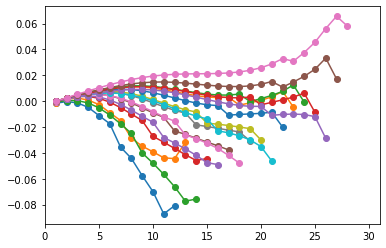

In [19]:
#Guess - True value

for n in range(19):
    cor = list_deltas[n+1] - list_guesses[n]
    plt.plot(np.arange(1,13+n),cor, "o-")
    plt.xlim(0,15+n)

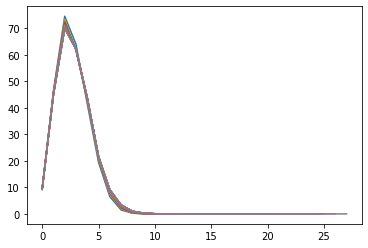

In [21]:
# Plot for rhos at different steps
for i, rho in enumerate(list_params_n):
    h = len(rho) // 2
    rho = rho[h:]
    plt.plot(rho)

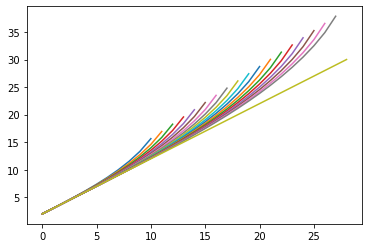

In [22]:
#Deltas vs index
list_deltas
for delta in list_deltas:
    plt.plot(delta)
xrange = np.arange(1,30)
plt.plot(1+xrange)

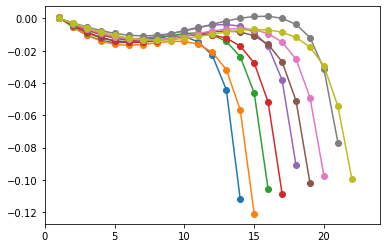

In [20]:
# Comparing guess from guess_generator and true value

def dilation(dnm1,dn, fixed_point = 1, some_point = 0):
    h =  len(dnm1) - some_point if len(dnm1) - some_point> 0 else len(dnm1)
    lambda_= (h+1 - fixed_point)/(h - fixed_point)
    epsilon = jnp.log((dn[h+1]-dn[fixed_point-1])/(dnm1[h] - dnm1[fixed_point-1]))/jnp.log(lambda_) 
    return epsilon

def guess_generator(dnm1, dn, fixed_point=1):
    
    epsilon = dilation(dnm1, dn, fixed_point,3)
    no_points = 1000
    x_range = jnp.linspace(1.0,int(len(dn)),(int(len(dn))- 1)*no_points)
    
    x_discrete = jnp.arange(1, int(len(dn)) + 1, dtype = float)
    
    yn = jnp.interp(x_range, x_discrete, dn)
    
    lambda_ = (len(dn))/(len(dn) - 1)
    
    scale = lambda_ ** epsilon
    
    ynp1 = (yn - yn[0]) * scale + yn[0]
    sample_rate = int((no_points-1)/ lambda_)
    guess = ynp1[::sample_rate]

    return guess

corrections = []
for n in range(1,10):
    guess = guess_generator(list_deltas[n], list_deltas[n+1], fixed_point=1)
    cor = guess - list_deltas[n+2]
    corrections.append(cor[-6:])
    plt.plot(np.arange(1,14+n),cor, "o-")
    plt.xlim(0,15+n)